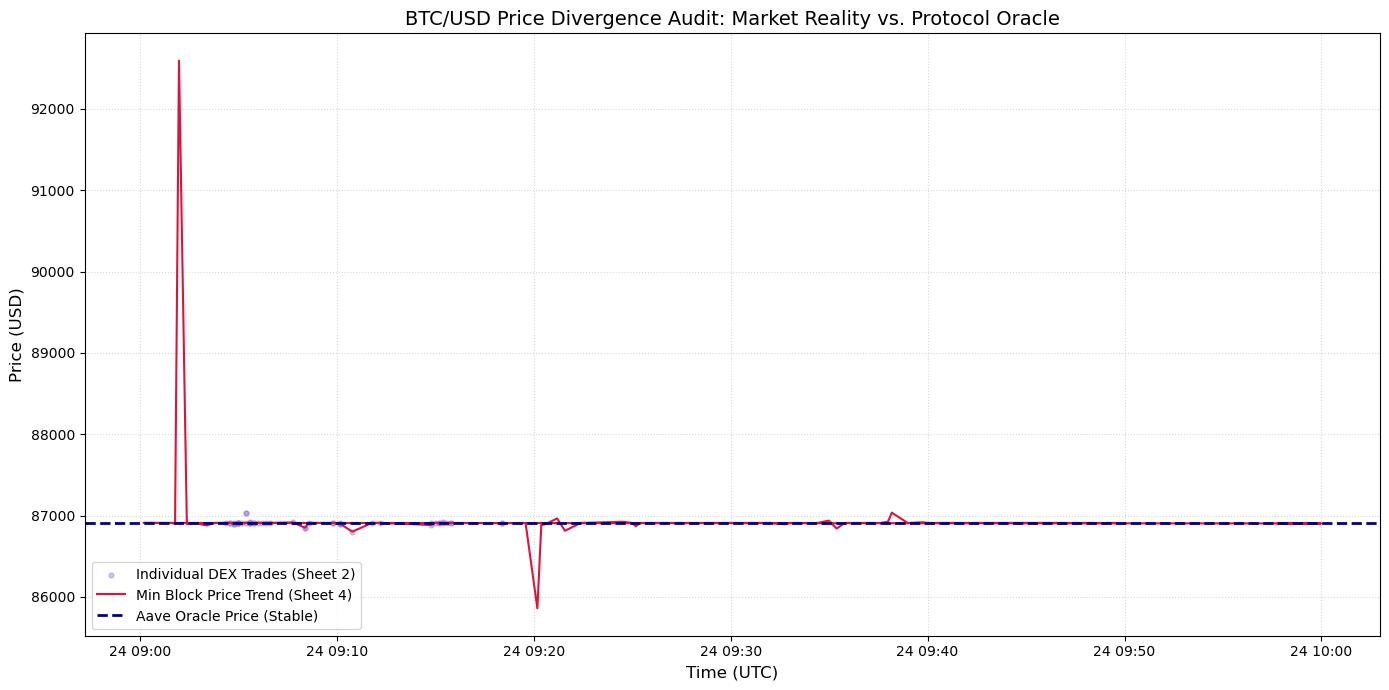

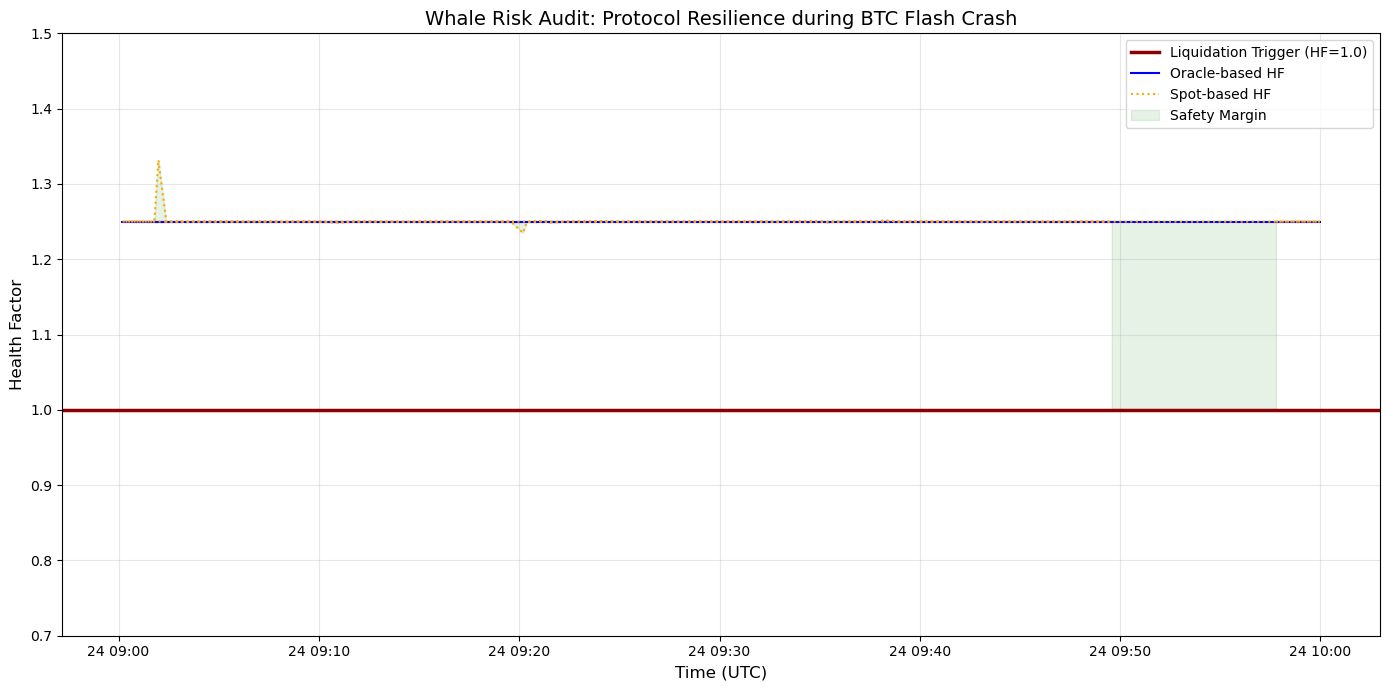

Audit Complete. Time format fixed. Results saved to BTC_Final_Audit_Results.csv


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Load Data ---
file_sheet4 = 'Sheet4.csv' 
file_sheet2 = 'Sheet2.csv'

df_blocks = pd.read_csv(file_sheet4)
df_raw = pd.read_csv(file_sheet2)

# --- 2. Fix Timestamps (Debugged Version) ---
def parse_broken_time(time_str):
    """
    Fixes Excel's truncated time format (e.g., '49:35.0' -> '2025-12-24 09:49:35')
    """
    time_str = str(time_str).strip()
    # If Excel format is MM:SS.f (missing the hour)
    if len(time_str.split(':')) == 2:
        return f"2025-12-24 09:{time_str}"
    # If the format is already HH:MM:SS
    elif len(time_str.split(':')) == 3:
        return f"2025-12-24 {time_str}"
    return time_str

# Apply the fix to both DataFrames
df_blocks['Block timestamp'] = pd.to_datetime(df_blocks['Block timestamp'].apply(parse_broken_time))
df_raw['Block timestamp'] = pd.to_datetime(df_raw['Block timestamp'].apply(parse_broken_time))

# Sort by block number for chronological order
df_blocks = df_blocks.sort_values('Block number')

# --- 3. Audit Parameters ---
# Baseline price from your Sheet 4 data
ORACLE_PRICE_BASE = 86908.0  
LIQUIDATION_THRESHOLD = 0.83 # Aave V3 Liquidation Threshold for WBTC

# --- 4. Simulate Whale #1 Position ---
# HF = (Collateral * Price * LT) / Debt
target_hf = 1.25
debt_usd = 50_000_000 # $50M simulation
collateral_wbtc = (target_hf * debt_usd) / (ORACLE_PRICE_BASE * LIQUIDATION_THRESHOLD)

# Calculate Health Factors
df_blocks['Oracle_HF'] = (collateral_wbtc * ORACLE_PRICE_BASE * LIQUIDATION_THRESHOLD) / debt_usd
df_blocks['Spot_HF'] = (collateral_wbtc * df_blocks['Min price'] * LIQUIDATION_THRESHOLD) / debt_usd

# --- 5. Visualization 1: Price Divergence Audit ---
plt.figure(figsize=(14, 7))

# Scatter Plot: Individual Trades (Sheet 2)
plt.scatter(df_raw['Block timestamp'], df_raw['Btc spot price usd'], 
            alpha=0.4, s=12, color='mediumpurple', label='Individual DEX Trades (Sheet 2)')

# Line Plot: Block-level Trend (Sheet 4)
plt.plot(df_blocks['Block timestamp'], df_blocks['Min price'], 
         color='crimson', linewidth=1.5, label='Min Block Price Trend (Sheet 4)')

# Baseline: Aave Oracle
plt.axhline(y=ORACLE_PRICE_BASE, color='navy', linestyle='--', linewidth=2, label='Aave Oracle Price (Stable)')

plt.title('BTC/USD Price Divergence Audit: Market Reality vs. Protocol Oracle', fontsize=14)
plt.xlabel('Time (UTC)', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='lower left')
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

# --- 6. Visualization 2: Whale Resilience Audit ---
plt.figure(figsize=(14, 7))

# Liquidation Line
plt.axhline(y=1.0, color='darkred', linestyle='-', linewidth=2.5, label='Liquidation Trigger (HF=1.0)')

# Health Factor Comparison
plt.plot(df_blocks['Block timestamp'], df_blocks['Oracle_HF'], label='Oracle-based HF', color='blue')
plt.plot(df_blocks['Block timestamp'], df_blocks['Spot_HF'], label='Spot-based HF', color='orange', linestyle=':')

# Fill Safety Margin
plt.fill_between(df_blocks['Block timestamp'], 1.0, df_blocks['Spot_HF'], 
                 where=(df_blocks['Spot_HF'] > 1.0), color='green', alpha=0.1, label='Safety Margin')

plt.title('Whale Risk Audit: Protocol Resilience during BTC Flash Crash', fontsize=14)
plt.xlabel('Time (UTC)', fontsize=12)
plt.ylabel('Health Factor', fontsize=12)
plt.ylim(0.7, 1.5)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- 7. Final Export ---
audit_results = df_blocks[['Block number', 'Block timestamp', 'Min price', 'Oracle_HF', 'Spot_HF']].copy()
audit_results.to_csv('BTC_Final_Audit_Results.csv', index=False)
print("Audit Complete. Time format fixed. Results saved to BTC_Final_Audit_Results.csv")